In [7]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

# Apply the transformations needed
import torchvision.transforms as T

# Define the helper function
def decode_segmap(image, source, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  
  rgb = np.stack([r, g, b], axis=2)

  # Load the foreground input image 
  foreground = cv2.imread(source)

  # Change the color of foreground image to RGB 
  # and resize image to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

  # Create a background array to hold white pixels
  # with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)

  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)  
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)  
  
  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)

  # Return a normalized output image for display
  return outImage/255



In [8]:
def segment(net, path, show_orig=True, dev='cpu'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
  rgb = decode_segmap(om, path)
    
  plt.imshow(rgb); plt.axis('off'); plt.show()
  
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

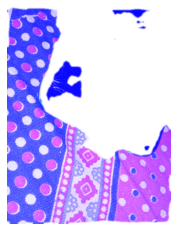

In [9]:
segment(dlab, './data/Datacluster Cracked Screen (7).jpg', show_orig=False)


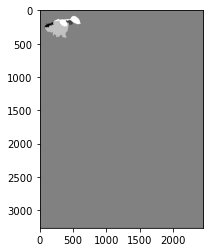

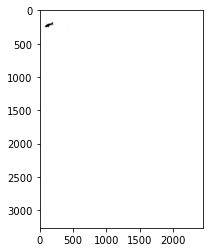

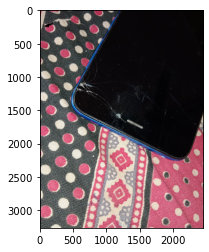

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("./data/Datacluster Cracked Screen (7).jpg", 3)

# Create a blank image of zeros (same dimension as img)
# It should be grayscale (1 color channel)
marker = np.zeros_like(img[:,:,0]).astype(np.int32)

# This step is manual. The goal is to find the points
# which create the result we want. I suggest using a
# tool to get the pixel coordinates.

# Dictate the background and set the markers to 1
marker[204][95] = 1
marker[240][137] = 1
marker[245][444] = 1
marker[260][427] = 1
marker[257][378] = 1
marker[217][466] = 1

# Dictate the area of interest
# I used different values for each part of the car (for visibility)
marker[235][370] = 255    # car body
marker[135][294] = 64     # rooftop
marker[190][454] = 64     # rear light
marker[167][458] = 64     # rear wing
marker[205][103] = 128    # front bumper

# rear bumper
marker[225][456] = 128
marker[224][461] = 128
marker[216][461] = 128

# front wheel
marker[225][189] = 192
marker[240][147] = 192

# rear wheel
marker[258][409] = 192
marker[257][391] = 192
marker[254][421] = 192

# Now we have set the markers, we use the watershed
# algorithm to generate a marked image
marked = cv2.watershed(img, marker)

# Plot this one. If it does what we want, proceed;
# otherwise edit your markers and repeat
plt.imshow(marked, cmap='gray')
plt.show()

# Make the background black, and what we want to keep white
marked[marked == 1] = 0
marked[marked > 1] = 255

# Use a kernel to dilate the image, to not lose any detail on the outline
# I used a kernel of 3x3 pixels
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(marked.astype(np.float32), kernel, iterations = 1)

# Plot again to check whether the dilation is according to our needs
# If not, repeat by using a smaller/bigger kernel, or more/less iterations
plt.imshow(dilation, cmap='gray')
plt.show()

# Now apply the mask we created on the initial image
final_img = cv2.bitwise_and(img, img, mask=dilation.astype(np.uint8))

# cv2.imread reads the image as BGR, but matplotlib uses RGB
# BGR to RGB so we can plot the image with accurate colors
b, g, r = cv2.split(final_img)
final_img = cv2.merge([r, g, b])

# Plot the final result
plt.imshow(final_img)
plt.show()

In [13]:
import numpy as np
import cv2
image_vec = cv2.imread('./data/Datacluster Cracked Screen (7).jpg', 1)
g_blurred = cv2.GaussianBlur(image_vec, (5, 5), 0)

In [17]:
blurred_float = g_blurred.astype(np.float32) / 255.0
edgeDetector = cv2.ximgproc.createStructuredEdgeDetection("model.yml")
edges = edgeDetector.detectEdges(blurred_float) * 255.0
cv2.imwrite('edge-raw.jpg', edges)

AttributeError: module 'cv2.cv2' has no attribute 'ximgproc'